In [1]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict,Literal
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_mistralai import ChatMistralAI
from pydantic import BaseModel, Field
import os 
load_dotenv()

True

In [2]:
model=ChatGoogleGenerativeAI(api_key=os.getenv("google"),model="gemini-2.5-flash")

In [3]:
class Sentiment(BaseModel):
    sentiment: Literal["positive", "negative", "neutral"] =Field(
        description="The sentiment of the text",
        examples="positive"
        
    )

google=model.with_structured_output(Sentiment)

In [4]:
class REVIEW(TypedDict):
    review: str
    sentiment: Literal["positive", "negative", "neutral"]
    response: str
    diagnosis:dict


In [5]:
graph=StateGraph(REVIEW)

In [6]:
class Diagnosis(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [7]:
model2=model.with_structured_output(Diagnosis)

In [14]:
def Sentiment_find(state:REVIEW)->REVIEW['sentiment']:
    prompt=f"what is the sentiment of the following review {state['review']}"
    Sentimenst=google.invoke(prompt).sentiment

    return {'sentiment':Sentimenst}

In [21]:
def check_sentiment(state:REVIEW)->Literal["positive_response", "negative_response", "neutral_response"]:
    sentiment=state['sentiment']
    if sentiment=="positive":
        return "positive_response"
    elif sentiment=="negative":
        return "negative_response"
    else:
        return "neutral_response"


def positive_response(state:REVIEW)->REVIEW['response']:
    prompt=f"write a positive response for the following review \m {state['review']}"
    response=model.invoke(prompt).content
    return {'response':response}

def neutral_response(state:REVIEW)->REVIEW['response']:
    prompt=f" give it a neutal response  {state['review']}"
    response=model.invoke(prompt).content
    return {'response':response}
def run_diagnosis(state:REVIEW)->REVIEW['diagnosis']:
    prompt = f"""Diagnose this negative review:\n\n{state['review']}\n"
    "Return issue_type, tone, and urgency.
"""
    response = model2.invoke(prompt)

    return {'diagnosis': response.model_dump()}

def negative_response(state:REVIEW)->REVIEW['response']:
    Diagnosis=state['diagnosis']
    prompt=f"you are a support assistant the user had a {Diagnosis['issue_type']} issue sounded {Diagnosis['tone']} and marked urgency {Diagnosis['urgency']} so write an empathetic helpful resolution message"
    response=model.invoke(prompt).content
    return {'response':response}

In [22]:

graph = StateGraph(REVIEW)

graph.add_node('find_sentiment', Sentiment_find)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)
graph.add_node('neutral_response', neutral_response)

graph.add_edge(START, 'find_sentiment')
graph.add_conditional_edges(
    'find_sentiment',
    check_sentiment,
    {
        "positive_response": "positive_response",
        "negative_response": "run_diagnosis",
        "neutral_response": "neutral_response"
    }
)
graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('positive_response', END)
graph.add_edge('negative_response', END)
graph.add_edge('neutral_response', END)

In [23]:
workflow=graph.compile()

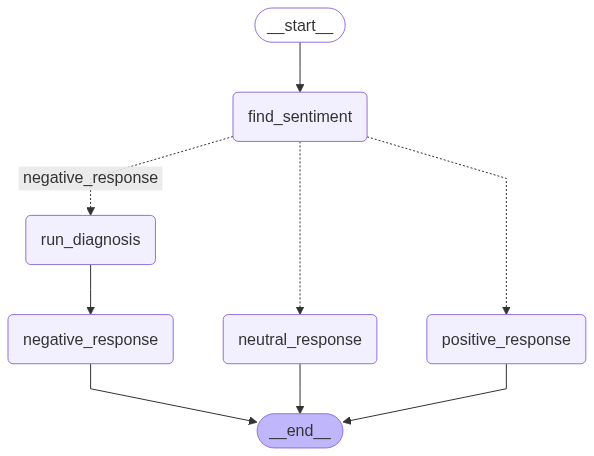

In [24]:
workflow

In [25]:
initial_state = {'review': 'I am not happy with the product but a bit happy with the services'}
workflow.invoke(initial_state)

{'review': 'I am not happy with the product but a bit happy with the services',
 'sentiment': 'negative',
 'response': 'Subject: Re: Your Recent "Other" Issue - We\'re Here to Help!\n\nHi [User\'s Name, if available, otherwise "Hello there"],\n\nI understand you\'ve reported an "Other" issue, and it sounds like you\'re feeling a bit disappointed about it. I\'m truly sorry to hear that you\'re having this experience.\n\nWhile you\'ve marked the urgency as low, please know that any issue impacting your experience is important to us, and we want to make sure you\'re completely satisfied.\n\nTo help us understand what\'s going on and get you the best possible support, could you please tell us a little more about what happened? Any details you can provide – what you were trying to do, what you expected to happen versus what did happen, or any specific observations – would be incredibly helpful.\n\nOnce we have a better understanding, we\'ll be able to investigate thoroughly and work towards